## **Project 6 - Unsupervised Learning**

### **Title**: *AllLife Bank Customer Segmentation*

### **Author**: *Pankaj Singh*

<br>

**Domain** 

Market analytics/Customer prediction

**Project Context**

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

**Data Description** 

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

**Customer Information** 

- **`Sl_No`** : Primary key of the records <br>
- **`Customer Key`** : Customer identification number <br>
- **`Average Credit Limit`** : Average credit limit of each customer for all credit cards <br>
- **`Total credit cards`** : Total number of credit cards possessed by the customer <br>
- **`Total visits bank`** : Total number of visits that customer made (yearly) personally to the bank <br>
- **`Total visits online`** : Total number of visits or online logins made by the customer (yearly)<br>
- **`Total calls made`** : Total number of calls made by the customer to the bank or its customer service department (yearly) <br>

**Project Deliverables**

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

**Learning Objective**

- Explore and visualize the dataset.
- Data preprocessing
- K-means clustering vs. Hierarchial clustering
- Generate a set of insights and recommendations that will help the bank

## **Import Libraries**

In [68]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# Libraries to help with data visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

# For supressing warnings
import warnings

warnings.filterwarnings("ignore")

# import markdown as md

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## **Load data \& get a first glimpse**

In [3]:
# Load data from csv file
data = pd.read_excel("Credit Card Customer Data.xlsx")
cust = data.copy()

<IPython.core.display.Javascript object>

- #### Shape of the dataset

In [4]:
## Print out the shape of the dataset
cust.shape

(660, 7)

<IPython.core.display.Javascript object>

- So we have 660 entries of our data
- We have 7 columns in our dataset

- #### A peek at the 5 random rows of the dataset

In [5]:
## Print out the random 5 rows of the data
cust.head(5)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


<IPython.core.display.Javascript object>

- #### Drop the redundant columns

- Sl_No does not seem to provide any useful information and is reduntant due to default indexing, so we will drop the `Sl_No` column
- `Customer Key` also doesn't add a lot of information but we will keep it for initial part of analysis to identify any customer who changed their habits. These are the entries with same `Customer Key` but different values for other features.

In [6]:
cust.drop(["Sl_No"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

- #### Look at the column names

In [7]:
## show the number of columns and column names
print("Total number of columns : ", len(cust.columns))
print("\nColumn names : \n\n", cust.columns.to_list())

Total number of columns :  6

Column names : 

 ['Customer Key', 'Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']


<IPython.core.display.Javascript object>

- #### Look at the missing values

In [8]:
# Show the null values
print("Missing values : \n\n", cust.isnull().sum().sort_values())

Missing values : 

 Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64


<IPython.core.display.Javascript object>

- No missing values in the original dataset

- #### Check for duplicate values

In [9]:
cust.duplicated().value_counts()

False    660
dtype: int64

<IPython.core.display.Javascript object>

- There are no duplicate values in the dataset

- #### Convert all column names to lower case and replace any spaces with underscore

In [10]:
cust.columns = cust.columns.str.lower()
cust.columns = cust.columns.str.replace(" ", "_")

<IPython.core.display.Javascript object>

- #### Pulling together numerical column names

In [11]:
# convert column names to list
numcols = cust.columns.to_list()
# remove customer_key as it is not going to be used in the analysis
numcols.remove("customer_key")

<IPython.core.display.Javascript object>

- #### Look at the simple statistical distribution of data

In [12]:
cust[numcols].describe().T

,count,mean,std,min,25%,50%,75%,max
avg_credit_limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
total_credit_cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


<IPython.core.display.Javascript object>

- #### Value counts for `customer_key`

In [13]:
cust_key_val_counts = cust["customer_key"].value_counts()
cust_key_val_counts[cust_key_val_counts > 1]

97935    2
50706    2
47437    2
37252    2
96929    2
Name: customer_key, dtype: int64

<IPython.core.display.Javascript object>

- As we can see that there are 10 entries which have duplicate `customer_key` value.
- We will further look into those `customer_key` values and look at the other feature values.

In [14]:
cust_key_duplicate = cust_key_val_counts[cust_key_val_counts == 2].index.to_list()
for cust_key in cust_key_duplicate:
    display(cust[cust["customer_key"] == cust_key])

,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
104,97935,17000,2,1,2,10
632,97935,187000,7,1,7,0


,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
411,50706,44000,4,5,0,2
541,50706,60000,7,5,2,2


,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
4,47437,100000,6,0,12,3
332,47437,17000,7,3,1,0


,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
48,37252,6000,4,0,2,8
432,37252,59000,6,2,1,2


,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
391,96929,13000,4,5,0,0
398,96929,67000,6,2,2,2


<IPython.core.display.Javascript object>

- After close investigation, we see that the double entry for `customer_key` refers to enitrely different values for other features.
- This indicates that the same customer has upgraded their credit card usage habits and it got captured as separate entry in the dataset.
- Hence, we can drop `customer_key` column, without losing any information.

In [15]:
cust.drop(["customer_key"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

## Observations:

- There are 660 rows in this data set and 5 columns


- The mean and median for avg_credit_limit are 35000 and 18000 respectively. There is a significant right skew in data.
    - The highest value for this feature is 200000, which is way higher than 75%-ile value of 48000, hence indicating presence of outliers
    
    
- The mean and median for total_credit_cards are 4.7 and 5 respectively. There is a slight left skew in data.
    - The highest value for this feature is 10, which is way higher than 75%-ile value of 6, hence indicating presence of outliers
    
    
- The mean and median for total_visits_bank are 2.4 and 2 respectively. There is a slight right skew in data.


- The mean and median for total_visits_online are 2.6 and 2 respectively. There is a slight right skew in data.
    - The highest value for this feature is 15, which is way higher than 75%-ile value of 4, hence indicating presence of outliers
    
    
- The mean and median for total_calls_made are 3.6 and 3 respectively. There is a slight right skew in data.
    - The highest value for this feature is 10, which is way higher than 75%-ile value of 5, hence indicating presence of outliers

## **Exploratory Data Analysis**

In [16]:
# function to show univariate analysis of continuous data columns
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

    f2.suptitle("SPREAD OF DATA FOR " + feature, fontsize=18, fontweight="bold")

<IPython.core.display.Javascript object>

- #### Pairplots

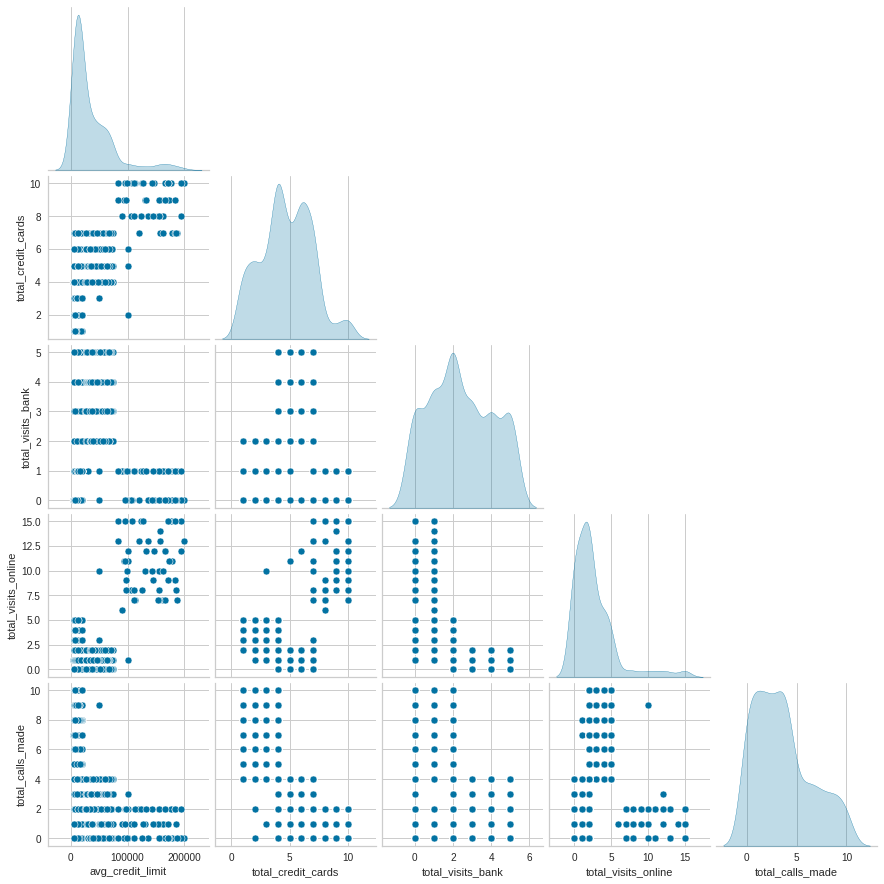

<IPython.core.display.Javascript object>

In [17]:
sns.pairplot(cust[numcols], corner=True, diag_kind="kde")

### Observations from Pairplots

- There seems to be two clusters w.r.t. avg_credit_limit, one group belonging to lower credit limit region and another group belonging to higher credit limit
    - A similar trend can be seen for total_credit_cards, two groups one with higher number of credit cards and one with less number of credit cards
    - There seems to be a positive correlation between the number of credit cards and the credit limit


- total_visits_online also seems to be clearly segmented, folks who use online banking or don't.

- #### Show correlation values

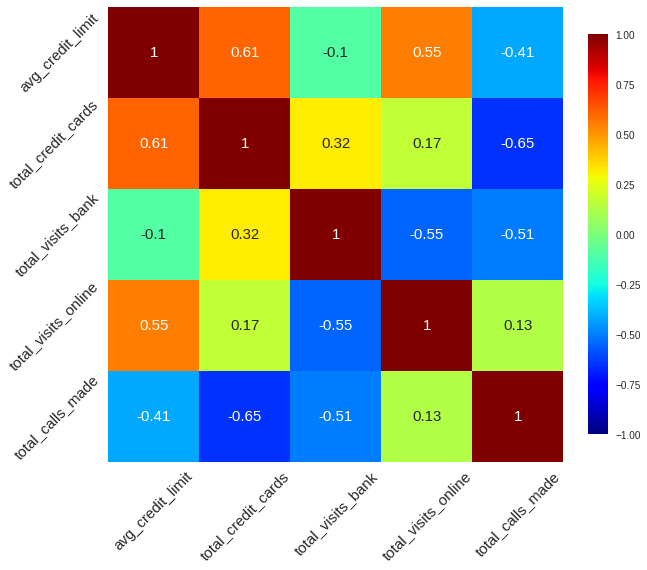

<IPython.core.display.Javascript object>

In [18]:
# Show the coorelation of numerical values on a color coded matrix

corr = cust[numcols].corr()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
fig.tight_layout(pad=2.0)

sns.heatmap(
    corr,
    annot=True,
    ax=ax,
    annot_kws={"fontsize": 15},
    cmap="jet",
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={"fraction": 0.04},
)
ax.tick_params(axis="both", rotation=45, labelsize=15)

### Observations from Correlation map

- As we guessed, there is a positive correlation between total_credit_cards and avg_credit_limit
- There is a negative correlation between total_visits_bank vs. both total_visits_online and total_calls_made
    - This seems to indicate that if the customers call/visit online they are most unlikely to visit the bank in person
    
    
- total_credit_cards has strong negative correlation with total_calls_made and a positive correlation with total_visits_online or total_visits_bank.
    - This indicates that the to maintain higher number of credit cards the customers online banking quite frequently and do not use the calling so much. 
    - If they need any further help even after using online banking, they would rather visit the bank in person.
    
    
- avg_credit_limit has a strong positive correlation with total_visits_online but a significant negative correlation with total_visits_bank and total_calls_made
    - Most likely to keep of the spending customers use the online banking more than the call or visits to the bank.

- #### Looping over all the numerical columns to show histogram barplot

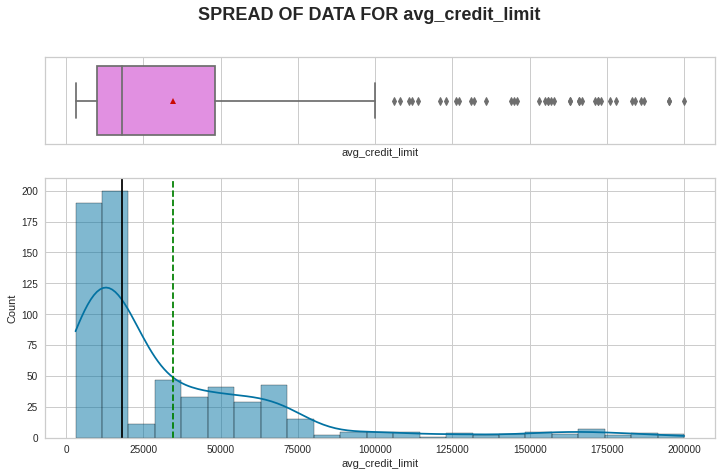

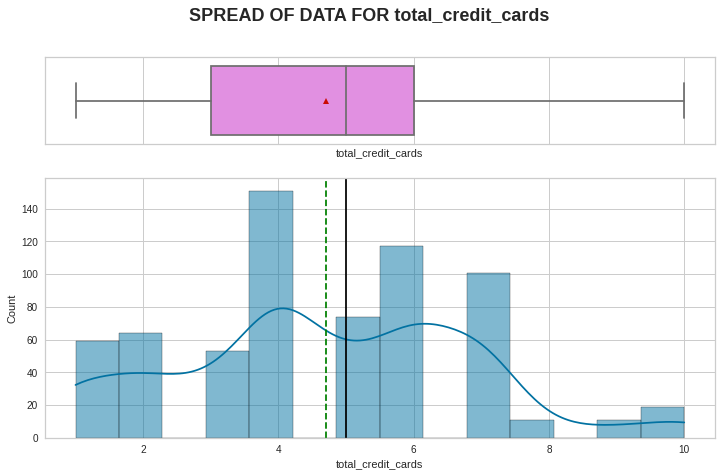

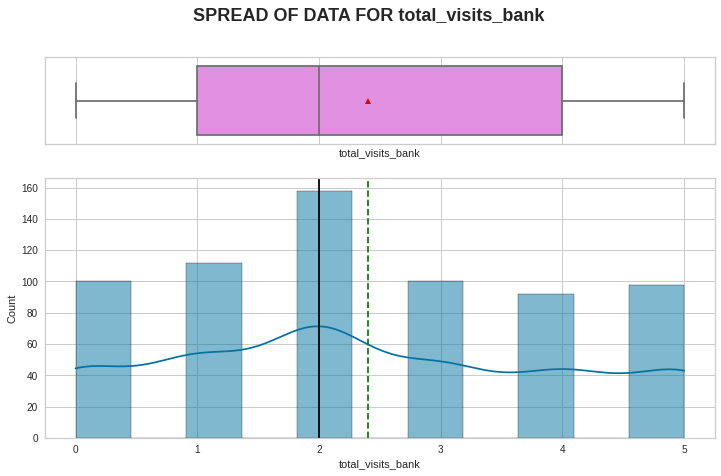

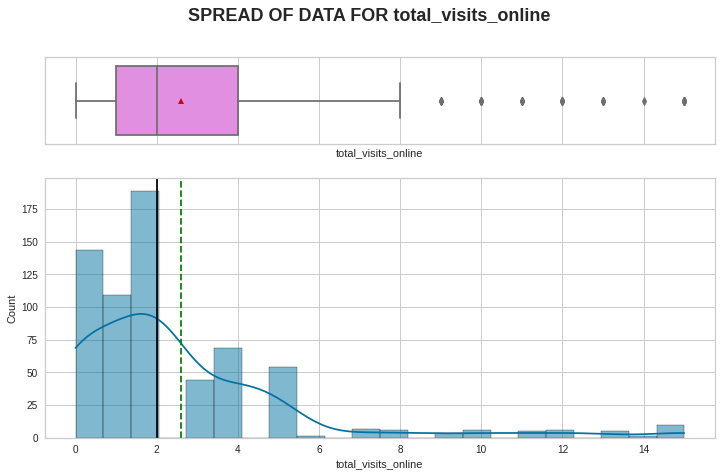

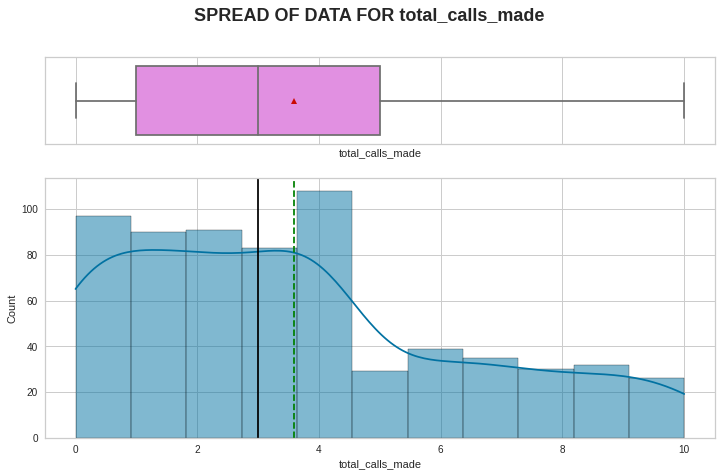

<IPython.core.display.Javascript object>

In [19]:
for numcol in numcols:
    histogram_boxplot(cust, numcol, figsize=(12, 7), kde=True, bins=None)

### Observations from Single variable distribution

- avg_credit_limit has 3 distinct regions where the credit limit lies,
    - One is a lower credit limit (< 25k) and has more than 50% of customers in that limit
    - There is group which has credit limit in the range (> 25k and < 75k)
    - The third group as very high credit limit ( > 75k )
    - There are outliers on the right end
    
- total_credit_cards seems to be a for uniform distribution
    - Some customers have unusually high number of credit cards (10)
      
- total_visits_bank seems to be a uniform distribution.

- total_visits_online has long right tail, indicating that there are customers who visit the website quite frequently. As we have seen in our analysis before that customers who visit online also have higher credit limit
    - There are outliers on the right end

- total_calls_made seems to be made up of two uniform distribution.

## Outlier identification and treatment 

Firstly we will identify which columns have significant number of outliers based on the %age data out of boxplot whisker range

In [20]:
## calculate the whisker values to identify outliers in the numerical data
Q1 = cust[numcols].quantile(0.25)
Q3 = cust[numcols].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR


def get_perc_outliers(data, feature, lower, upper):

    print(f"% data beyond upper and lower whiskers for {feature}\n")
    print(
        f"data below lower whisker = {100 * (data[data[feature] < lower].shape[0]) / data.shape[0]:.2f}%"
    )
    print(
        f"data beyond upper whisker = {100 * (data[data[feature] > upper].shape[0]) / data.shape[0]:.2f}%"
    )

    print("-" * 40, "\n")


for numcol in numcols:
    get_perc_outliers(cust, numcol, lower_whisker[numcol], upper_whisker[numcol])

% data beyond upper and lower whiskers for avg_credit_limit

data below lower whisker = 0.00%
data beyond upper whisker = 5.91%
---------------------------------------- 

% data beyond upper and lower whiskers for total_credit_cards

data below lower whisker = 0.00%
data beyond upper whisker = 0.00%
---------------------------------------- 

% data beyond upper and lower whiskers for total_visits_bank

data below lower whisker = 0.00%
data beyond upper whisker = 0.00%
---------------------------------------- 

% data beyond upper and lower whiskers for total_visits_online

data below lower whisker = 0.00%
data beyond upper whisker = 5.61%
---------------------------------------- 

% data beyond upper and lower whiskers for total_calls_made

data below lower whisker = 0.00%
data beyond upper whisker = 0.00%
---------------------------------------- 



<IPython.core.display.Javascript object>

- avg_credit_limit and total_visits_online have highest amount of outlier data and it is on the right end of the distribution
    - Other features do not have any outliers
    - Let us analyze avg_credit_limit and total_visits_online one by one

- #### avg_credit_limit outlier analysis

In [21]:
cust[cust["avg_credit_limit"] > upper_whisker["avg_credit_limit"]][
    "avg_credit_limit"
].describe()

count        39.000000
mean     154205.128205
std       26715.045522
min      106000.000000
25%      131500.000000
50%      157000.000000
75%      172500.000000
max      200000.000000
Name: avg_credit_limit, dtype: float64

<IPython.core.display.Javascript object>

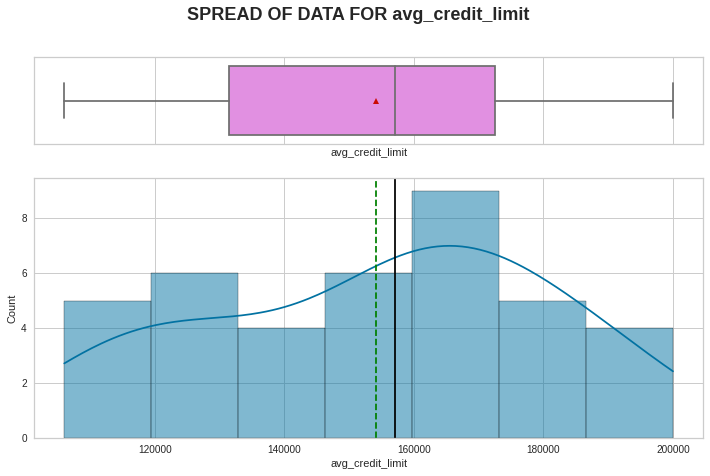

<IPython.core.display.Javascript object>

In [22]:
histogram_boxplot(
    cust[cust["avg_credit_limit"] > upper_whisker["avg_credit_limit"]],
    "avg_credit_limit",
    figsize=(12, 7),
    kde=True,
    bins=None,
)

- The distribution of avg_credit_limit beyond the right whisker of it seems to be a uniform distribution in itself.
    - The mean and median values are close to each other
- We will keep those values as they seem to represent real credit limits of real customers.

- #### total_visits_online outlier analysis

In [23]:
cust[cust["total_visits_online"] > upper_whisker["total_visits_online"]].describe()

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
count,37.000000,37.000000,37.000000,37.000000,37.000000
mean,139945.945946,8.675676,0.567568,12.216216,1.378378
std,38128.398534,1.633912,0.502247,2.123089,1.569702
min,50000.000000,3.000000,0.000000,9.000000,0.000000
25%,100000.000000,8.000000,0.000000,10.000000,0.000000
50%,145000.000000,9.000000,1.000000,12.000000,1.000000
75%,172000.000000,10.000000,1.000000,15.000000,2.000000
max,200000.000000,10.000000,1.000000,15.000000,9.000000


<IPython.core.display.Javascript object>

In [24]:
cust[cust["total_visits_online"] > upper_whisker["total_visits_online"]].groupby(
    "total_visits_online"
).agg(["mean", "count"])

avg_credit_limit       total_credit_cards        \
                                mean count               mean count   
total_visits_online                                                   
9                      149250.000000     4           9.250000     4   
10                     123833.333333     6           8.000000     6   
11                     128200.000000     5           8.000000     5   
12                     151000.000000     6           8.833333     6   
13                     139800.000000     5           8.400000     5   
14                     157000.000000     1           9.000000     1   
15                     143500.000000    10           9.200000    10   

                    total_visits_bank       total_calls_made        
                                 mean count             mean count  
total_visits_online                                                 
9                            0.750000     4              1.5     4  
10                           0.666667     6              2.5     6  
11                           0.600000     5              0.8     5  
12                           0.500000     6              2.0     6  
13                           0.200000     5              0.8     5  
14                           1.000000     1              1.0     1  
15                           0.600000    10              0.9    10

<IPython.core.display.Javascript object>

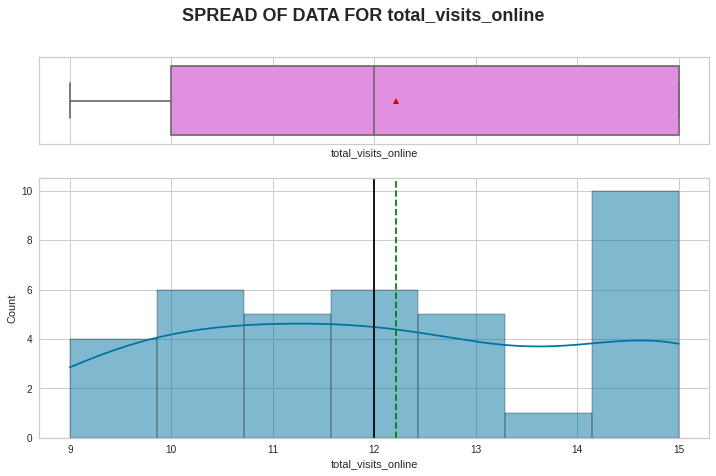

<IPython.core.display.Javascript object>

In [25]:
histogram_boxplot(
    cust[cust["total_visits_online"] > upper_whisker["total_visits_online"]],
    "total_visits_online",
    figsize=(12, 7),
    kde=True,
    bins=None,
)

- When taking a close look at the dataset for which the values of total_visits_online is beyond the right whisker, we can notice follwing facts,
    - The distribution of total_visits_online in the outlier range is almost a uniform distribution
    - The mean of avg_credit_limit and total_credit_cards are much higher than the overall dataset
    - The mean of total_visits_bank and total_calls_made are lower than the overall dataset
    
    
- Since these outlier values seemed to be closely linked with the higher avg_credit_limit and total_credit_card, they are tied upto a customer cluster with some unique features (high avg_credit_limit, total_credit_cards and total_visits_online). Hence, we will keep those values for further analysis.

### Data scaling

In [26]:
# Define the standard scaler
scaler = StandardScaler()

# Create a copy of unscaled data
cust_unscaled_km = cust.copy()

# Create scaled data and assign it to a dataframe
cust_scaled_km = pd.DataFrame(
    scaler.fit_transform(cust_unscaled_km), columns=cust_unscaled_km.columns
)

# Verify the scaling of the dataset
cust_scaled_km.describe()

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
count,6.600000e+02,6.600000e+02,6.600000e+02,6.600000e+02,6.600000e+02
mean,8.195465e-16,-4.006223e-15,1.157323e-16,1.944572e-16,-7.112156e-16
std,1.000758e+00,1.000758e+00,1.000758e+00,1.000758e+00,1.000758e+00
min,-8.398081e-01,-1.710864e+00,-1.473731e+00,-8.883795e-01,-1.251537e+00
25%,-6.536229e-01,-7.875852e-01,-8.604506e-01,-5.474897e-01,-9.022711e-01
50%,-4.408398e-01,1.356941e-01,-2.471705e-01,-2.065999e-01,-2.037386e-01
75%,3.570968e-01,5.973337e-01,9.793898e-01,4.751797e-01,4.947938e-01
max,4.399975e+00,2.443892e+00,1.592670e+00,4.224968e+00,2.241125e+00


<IPython.core.display.Javascript object>

- The standard scaling of the dataset looks good,
    - The mean is nearly zero for all features
    - The standard deviation of all features is close to 1

## **K-mean clustering**

- Here we will first evaluate KMeans cluster with number of clusters ranging from 1 to 15.
- We will plot the mean distortions for each given number of cluster and generate the elbow plot

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9426543606899347
Number of Clusters: 7 	Average Distortion: 0.9093991915419353
Number of Clusters: 8 	Average Distortion: 0.8843243844476886
Number of Clusters: 9 	Average Distortion: 0.8650832420580971
Number of Clusters: 10 	Average Distortion: 0.8411372125672628
Number of Clusters: 11 	Average Distortion: 0.8231750888188953
Number of Clusters: 12 	Average Distortion: 0.7988149412241276
Number of Clusters: 13 	Average Distortion: 0.7839044657265694
Number of Clusters: 14 	Average Distortion: 0.7693436848514908


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

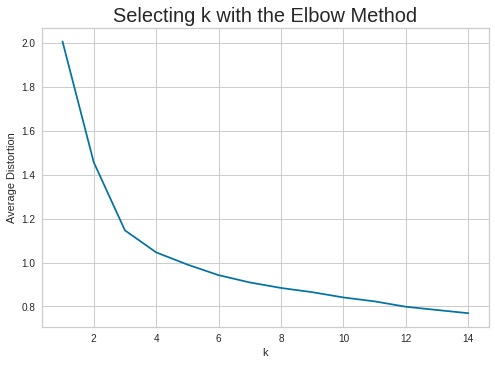

<IPython.core.display.Javascript object>

In [27]:
clusters = range(1, 15)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(cust_scaled_km)
    prediction = model.predict(cust_scaled_km)
    distortion = (
        sum(np.min(cdist(cust_scaled_km, model.cluster_centers_, "euclidean"), axis=1))
        / cust_scaled_km.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

- Based on this elbow plot, we can notice that a **significant elbow is present at 3**. But we will also analyze 4 and 6 as they qualitatively seem to have an elbow as well.

- To look further deep, we will calculate the silhouette score for clusters ranging from 2 to 7. We will also visualize the individual clusters silhoutte score using silhouttevisualizer.

For n_clusters = 2, silhouette score is 0.41842496663230405
For n_clusters = 3, silhouette score is 0.5157182558882754
For n_clusters = 4, silhouette score is 0.355667061937737
For n_clusters = 5, silhouette score is 0.2717470361094591
For n_clusters = 6, silhouette score is 0.25590676529850875
For n_clusters = 7, silhouette score is 0.2479864465613871


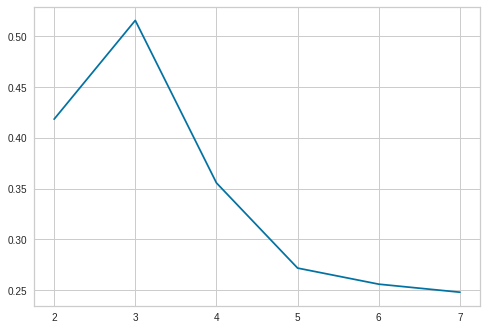

<IPython.core.display.Javascript object>

In [28]:
sil_score = []
cluster_list = list(range(2, 8))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict((cust_scaled_km))
    score = silhouette_score(cust_scaled_km, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

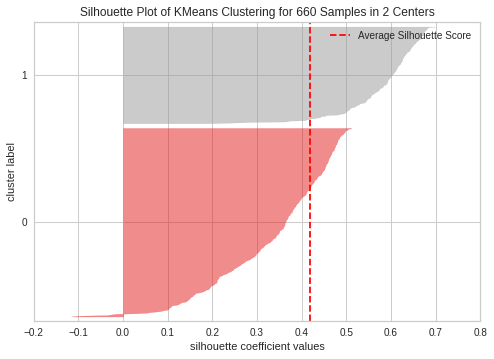

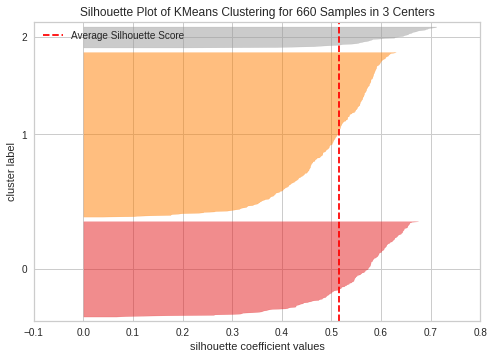

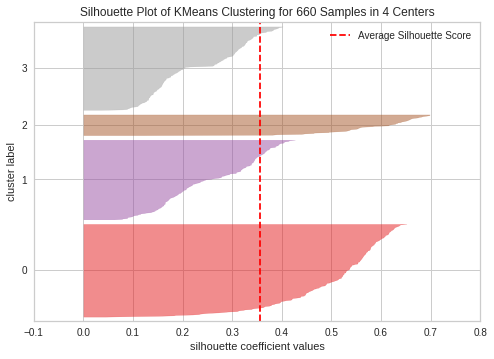

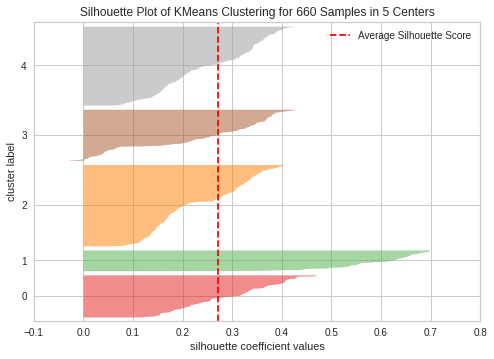

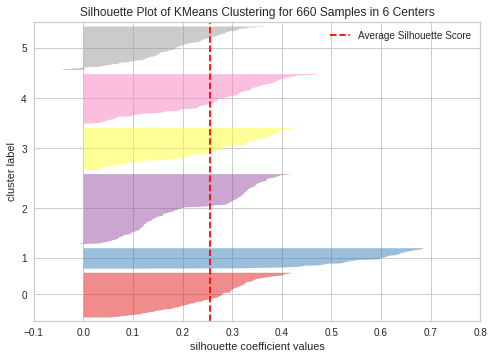

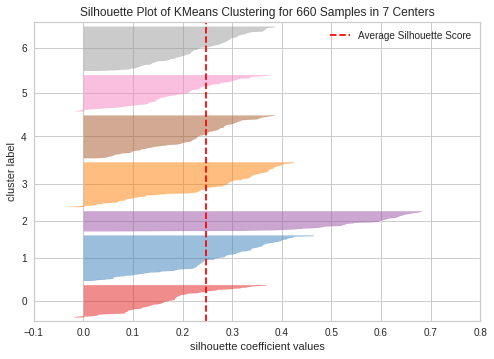

<IPython.core.display.Javascript object>

In [29]:
# finding optimal no. of clusters with silhouette coefficients
sil_score = []
cluster_list = list(range(2, 8))

for n_clusters in cluster_list:
    visualizer = SilhouetteVisualizer(KMeans(n_clusters, random_state=1))
    visualizer.fit(cust_scaled_km)
    visualizer.show()

- Based on the mean silhoutte score values, we get the **highest value at 3 clusters**.
- All the individual clusters silhoutte scores are well above the mean value
- Next, we will summarize the clusterwise mean metrics for all the features.

In [30]:
## Calculate Kmeans cluster with ncluster = 3
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(cust_scaled_km)

## Add the cluster label to the unscaled data set
cust_unscaled_km["cluster_ID_km"] = kmeans.labels_

## Reassign cluster names in the decreasing order of cluster size
cust_unscaled_km["cluster_ID_km"].replace([0, 1, 2], [2, 1, 3], inplace=True)

## Generate cluster profile with mean values of the features
cluster_profile_km = cust_unscaled_km.groupby("cluster_ID_km").mean()
cluster_profile_km["cluster_count"] = (
    cust_unscaled_km.groupby("cluster_ID_km")["avg_credit_limit"].count().values
)

# let's display the maximum values amonng the 3 clusters for each feature
display(cluster_profile_km.style.highlight_max(color="lightgreen", axis=0))

# let's display the minimum values amonng the 3 clusters for each feature
display(cluster_profile_km.style.highlight_min(color="lightblue", axis=0))

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,cluster_count
cluster_ID_km,,,,,,
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,12174.107143,2.410714,0.933036,3.553571,6.870536,224
3,141040.000000,8.740000,0.600000,10.900000,1.080000,50


,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,cluster_count
cluster_ID_km,,,,,,
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,12174.107143,2.410714,0.933036,3.553571,6.870536,224
3,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

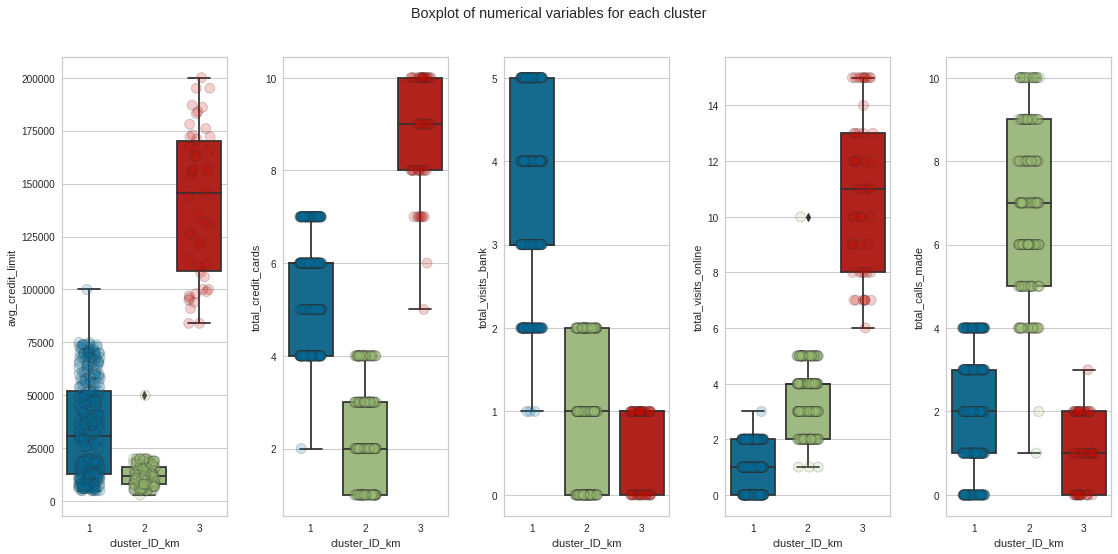

<IPython.core.display.Javascript object>

In [31]:
fig, axes = plt.subplots(1, len(numcols), figsize=(16, 8))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for i in range(len(numcols)):
    sns.boxplot(
        ax=axes[i], y=cust_unscaled_km[numcols[i]], x=cust_unscaled_km["cluster_ID_km"],
    )
    sns.stripplot(
        data=cust_unscaled_km,
        x="cluster_ID_km",
        y=numcols[i],
        jitter=0.2,
        ax=axes[i],
        alpha=0.2,
        linewidth=1,
        size=10,
    )
fig.tight_layout(pad=2.0)

- Here we will summarize our cluster characteristics,
    - Cluster 1
        - Customers in this cluster have high total_visits_bank
        - They have the lowest values of total_visits_online
    - Cluster 2
        - Customers in this cluster have high total_calls_made
        - They have the lowest values of avg_credit_limit and total_credit_cards
    - Cluster 3
        - Customers in this cluster have high avg_credit_limit, total_credit_cards and total_visits_online
        - They have the lowest values of total_visits_bank and total_calls_made


- Based on features we can describe out clusters as follows,
    1. Based on avg_credit_limit this is the order, cluster 3 > cluster 1 > cluster 2
    2. Based on total_credit_cards this is the order, cluster 3 > cluster 1 > cluster 2
    3. Based on mode of contact following is each cluster's preference,
        - cluster 2 => calling
        - cluster 1 => bank visits
        - cluster 3 => online banking

## Hierarchical Clustering

- Creating a new scaled datset for heirarchical clustering just like the one we created for K-Means

In [32]:
# Create a copy of unscaled data
cust_unscaled_hc = cust.copy()
# Create scaled data and assign it to a dataframe
cust_scaled_hc = pd.DataFrame(
    scaler.fit_transform(cust_unscaled_hc), columns=cust_unscaled_hc.columns
)

<IPython.core.display.Javascript object>

- Let's calculate cophenetic coefficient for various combinations of distance and linkage metrics

In [33]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(cust_scaled_hc, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(cust_scaled_hc))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm
    print("\n")
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.


Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.


Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553607.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.542279120980175.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042137.
Cophenetic

<IPython.core.display.Javascript object>

- We see that Euclidean distance with average linkage gives a significantly high cophenectic coefficient.
- We will further explore the dendograms with Euclidean distance and use different linkage methods

In [34]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(cust_scaled_hc, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(cust_scaled_hc))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm


# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print("\n")
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


<IPython.core.display.Javascript object>

- Euclidean distance with average linkage seems to give a high cophenectic correlation
- We will explore these linkage methods with Euclidean distance with the help of dendograms

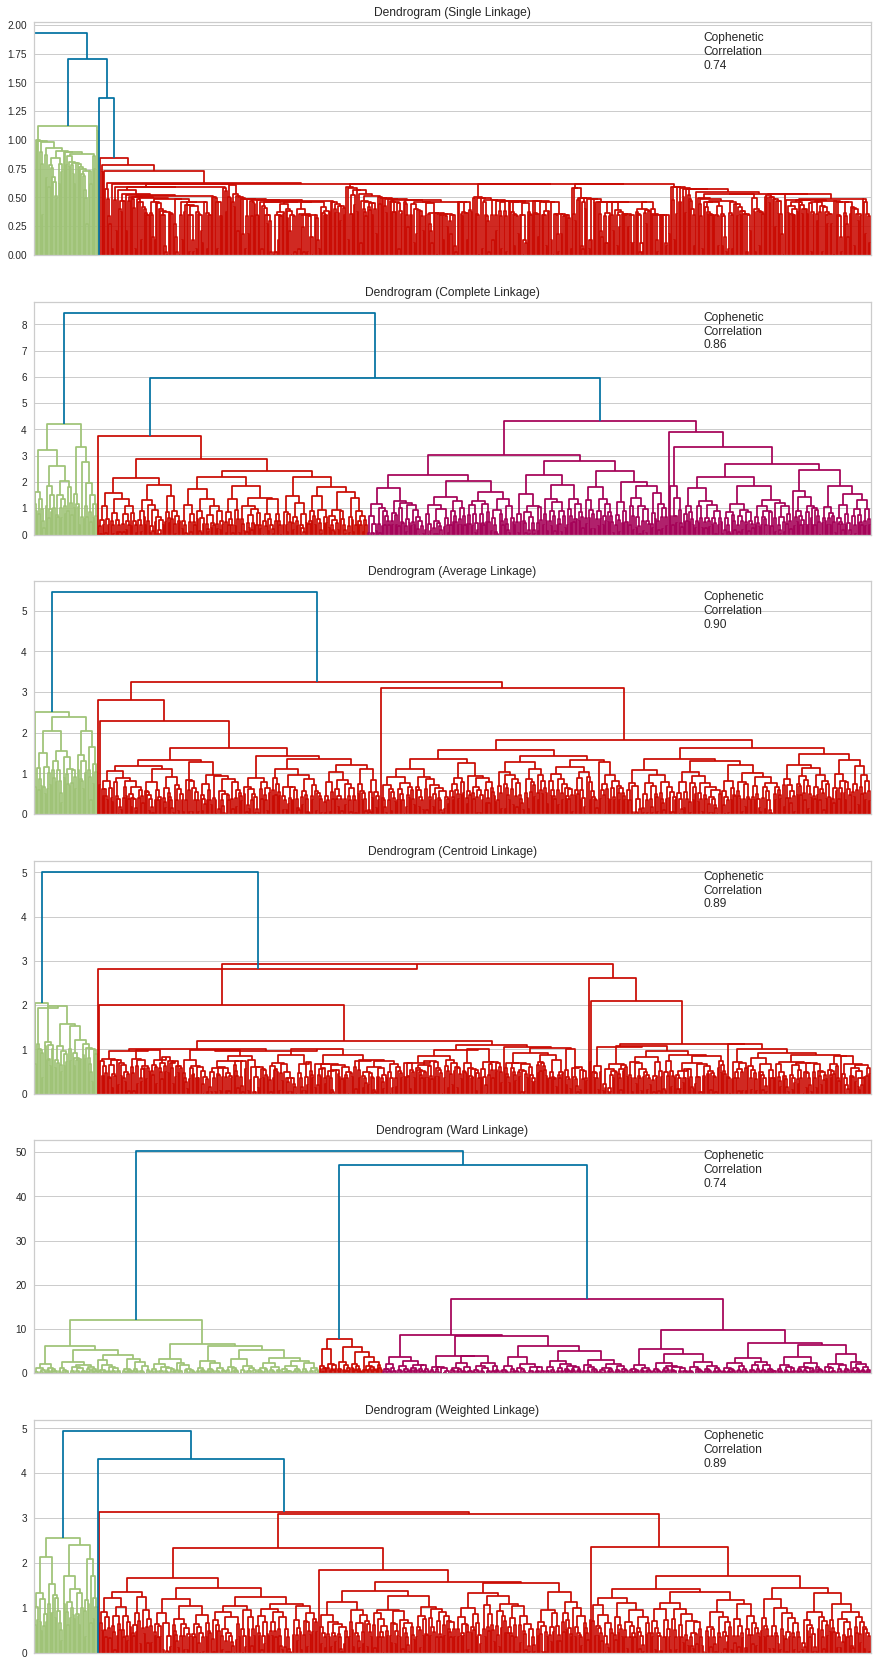

<IPython.core.display.Javascript object>

In [35]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(cust_scaled_hc, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(cust_scaled_hc))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    axs[i].axes.xaxis.set_visible(False)

- Average, centroid and weighted linkage show the highest cophenectic correlation, but their dendogram do not look balanced.
    - Their dendogram seems to be dominant by one cluster (~90% of data) 
- **Complete** and **Ward** linkage seem to have 3 clear clusters which we will further explore and compare

- #### Visualize dendrogram cut for Ward linkage

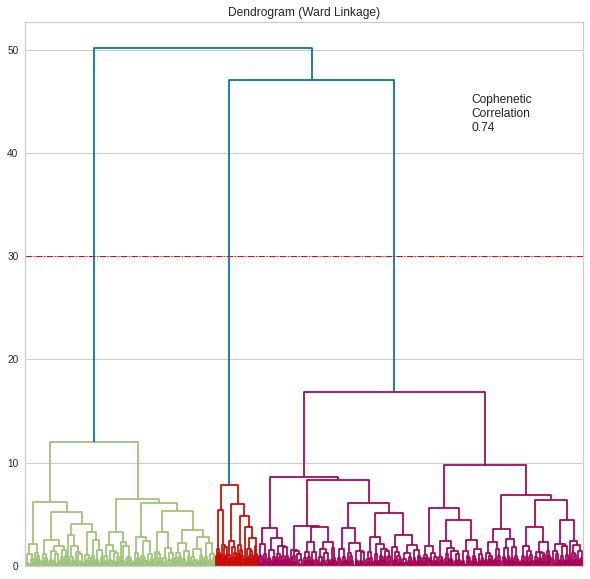

<IPython.core.display.Javascript object>

In [36]:
# list of linkage methods
linkage_methods = ["ward"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(10, 10))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(cust_scaled_hc, metric="euclidean", method=method)

    dendrogram(Z, ax=axs)
    axs.set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(cust_scaled_hc))
    axs.annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
    axs.axes.xaxis.set_visible(False)
plt.axhline(y=30, c="red", lw=1, linestyle="dashdot")

- #### Visualize dendrogram cut for Complete linkage

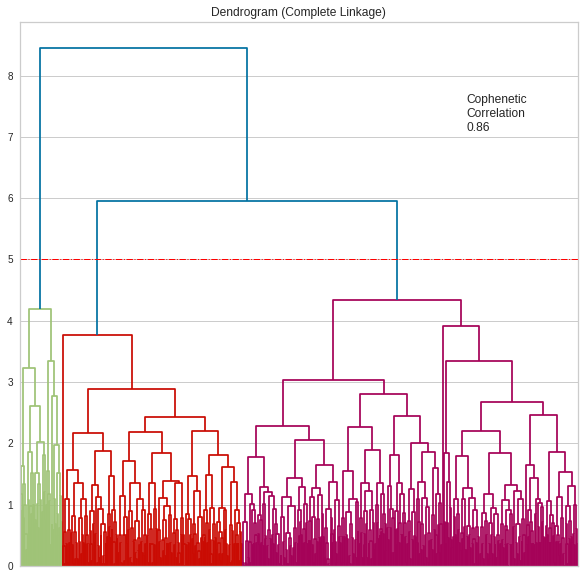

<IPython.core.display.Javascript object>

In [37]:
# list of linkage methods
linkage_methods = ["complete"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(10, 10))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(cust_scaled_hc, metric="euclidean", method=method)

    dendrogram(Z, ax=axs)
    axs.set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(cust_scaled_hc))
    axs.annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
    axs.axes.xaxis.set_visible(False)
plt.axhline(y=5, c="red", lw=1, linestyle="dashdot")

### Hierarchical Clustering

In [38]:
## Hierarchical clustering using complete linkage
HCmodel_complete = AgglomerativeClustering(
    n_clusters=3, affinity="euclidean", linkage="complete"
)
HCmodel_complete.fit(cust_scaled_hc)

cust_scaled_hc["hc_complete"] = HCmodel_complete.labels_

## Hierarchical clustering using ward linkage
HCmodel_ward = AgglomerativeClustering(
    n_clusters=3, affinity="euclidean", linkage="ward"
)
HCmodel_ward.fit(cust_scaled_hc)

cust_scaled_hc["hc_ward"] = HCmodel_ward.labels_

<IPython.core.display.Javascript object>

### Cluster Profiling

In [39]:
## Cluster profile from hierarchical clustering with complete linkage
cluster_profile_hc_complete = cust_scaled_hc.groupby("hc_complete").mean()
cluster_profile_hc_complete["count_in_each_segments"] = (
    cust_scaled_hc.groupby("hc_complete")["avg_credit_limit"].count().values
)

## Cluster profile from hierarchical clustering with ward linkage
cluster_profile_hc_ward = cust_scaled_hc.groupby("hc_ward").mean()
cluster_profile_hc_ward["count_in_each_segments"] = (
    cust_scaled_hc.groupby("hc_ward")["avg_credit_limit"].count().values
)

# let's display the averages of the 3 clusters obtained using complete and ward linkages
display(cluster_profile_hc_complete)
display(cluster_profile_hc_ward)

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,hc_ward,count_in_each_segments
hc_complete,,,,,,,
0,-0.037852,0.348490,0.614820,-0.544055,-0.531891,0.0,397
1,2.831764,1.862226,-1.105763,2.827319,-0.874330,2.0,50
2,-0.594183,-1.086676,-0.886364,0.350347,1.196606,1.0,213


,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,hc_complete,count_in_each_segments
hc_ward,,,,,,,
0,-0.037852,0.348490,0.614820,-0.544055,-0.531891,0.0,397
1,-0.594183,-1.086676,-0.886364,0.350347,1.196606,2.0,213
2,2.831764,1.862226,-1.105763,2.827319,-0.874330,1.0,50


<IPython.core.display.Javascript object>

- When displayed next to each other, we can see that ward and complete linkages are resulting in exactly same clusters except their names indices are different. 
- So we will drop separate labels for ward and complete linkages and continue with complete linkage cluster labels.

In [40]:
## Cluster profile from hierarchical clustering with complete linkage
cust_unscaled_hc["cluster_ID_hc"] = HCmodel_complete.labels_
cust_unscaled_hc["cluster_ID_hc"].replace([0, 2, 1], [1, 2, 3], inplace=True)

## Cluster profile from hierarchical clustering
cluster_profile_hc = cust_unscaled_hc.groupby("cluster_ID_hc").mean()
cluster_profile_hc["cluster_count"] = (
    cust_unscaled_hc.groupby("cluster_ID_hc")["avg_credit_limit"].count().values
)

## Display the heirarchical clustering
cluster_profile_hc

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,cluster_count
cluster_ID_hc,,,,,,
1,33151.133501,5.460957,3.405542,1.010076,2.060453,397
2,12234.741784,2.352113,0.957746,3.633803,7.009390,213
3,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

- Display the box plot of clusters obtained from Hierarchial clustering

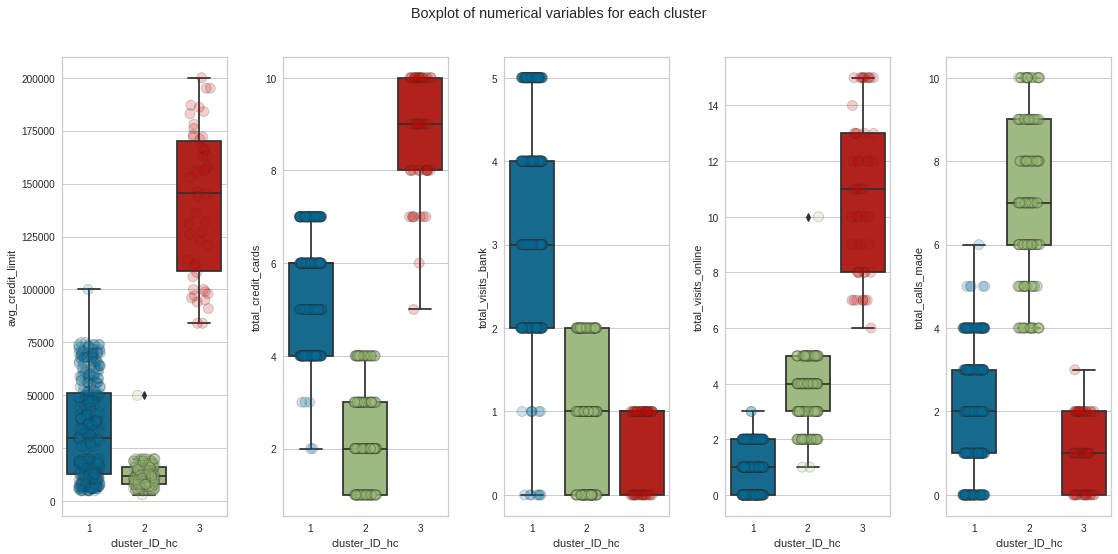

<IPython.core.display.Javascript object>

In [41]:
fig, axes = plt.subplots(1, len(numcols), figsize=(16, 8))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for i in range(len(numcols)):
    sns.boxplot(
        ax=axes[i], y=cust_unscaled_hc[numcols[i]], x=cust_unscaled_hc["cluster_ID_hc"],
    )
    sns.stripplot(
        data=cust_unscaled_hc,
        x="cluster_ID_hc",
        y=numcols[i],
        jitter=0.2,
        ax=axes[i],
        alpha=0.2,
        linewidth=1,
        size=10,
    )
fig.tight_layout(pad=2.0)

## Comparison between K-Means and Hierarchial clustering

In [42]:
display(cluster_profile_km)
display(cluster_profile_hc)

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,cluster_count
cluster_ID_km,,,,,,
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,12174.107143,2.410714,0.933036,3.553571,6.870536,224
3,141040.000000,8.740000,0.600000,10.900000,1.080000,50


,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,cluster_count
cluster_ID_hc,,,,,,
1,33151.133501,5.460957,3.405542,1.010076,2.060453,397
2,12234.741784,2.352113,0.957746,3.633803,7.009390,213
3,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

- The cluster 3 is of exact same size and has same averages of the features.
- The cluster 1 of K-Means has fewer entries in it compared to cluster 1 of Heirerchial clustering and vice versa is true for cluster 2. There are 11 such data points
- We will take a little closer look into these 11 data points.

In [43]:
# Create a dataset with both K-Means and Hierarchial clustering labels
cust_km_hc = cust_unscaled_km.copy()
cust_km_hc["cluster_ID_hc"] = HCmodel_complete.labels_
cust_km_hc["cluster_ID_hc"].replace([0, 2, 1], [1, 2, 3], inplace=True)

<IPython.core.display.Javascript object>

In [44]:
cust_km_hc[(cust_km_hc["cluster_ID_hc"] == 1) & (cust_km_hc["cluster_ID_km"] == 2)][
    numcols
].describe()

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
count,11.000000,11.000000,11.000000,11.000000,11.000000
mean,11000.000000,3.545455,0.454545,2.000000,4.181818
std,4898.979486,0.687552,0.687552,0.447214,1.470930
min,5000.000000,2.000000,0.000000,1.000000,1.000000
25%,7000.000000,3.000000,0.000000,2.000000,4.000000
50%,11000.000000,4.000000,0.000000,2.000000,5.000000
75%,14500.000000,4.000000,1.000000,2.000000,5.000000
max,20000.000000,4.000000,2.000000,3.000000,6.000000


<IPython.core.display.Javascript object>

- It is hard to make comparison between two clusters based on mean and median values.
- So we will use PCA analysis to reduce the number of features and use visualizations

## PCA analysis

- First we run PCA analysis with n_components = no of features to see how many PCA components would be suitable for our need

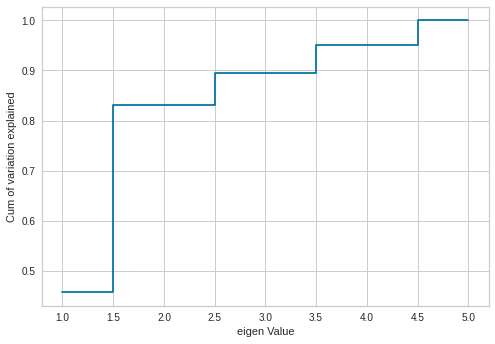

<IPython.core.display.Javascript object>

In [45]:
# setting the number of components to 5
pca = PCA(n_components=5)

# Create a copy of unscaled data
cust_unscaled_pca = cust.copy()

# Create scaled data and assign it to a dataframe
cust_scaled_pca = pd.DataFrame(
    scaler.fit_transform(cust_unscaled_pca), columns=cust_unscaled_pca.columns
)

# transforming data and storing results in a dataframe
pca.fit_transform(cust_scaled_pca)

# Plot the cumulative sum of explained variance  ratio
plt.step(list(range(1, 6)), np.cumsum(pca.explained_variance_ratio_), where="mid")
plt.ylabel("Cum of variation explained")
plt.xlabel("eigen Value")
plt.show()

- 2 features will explain 83% of variance
- 3 features will explain 90% of variance

### Visualize clusters using 2 features PCA

Text(0.5, 1.0, 'Clusters using K-Means')

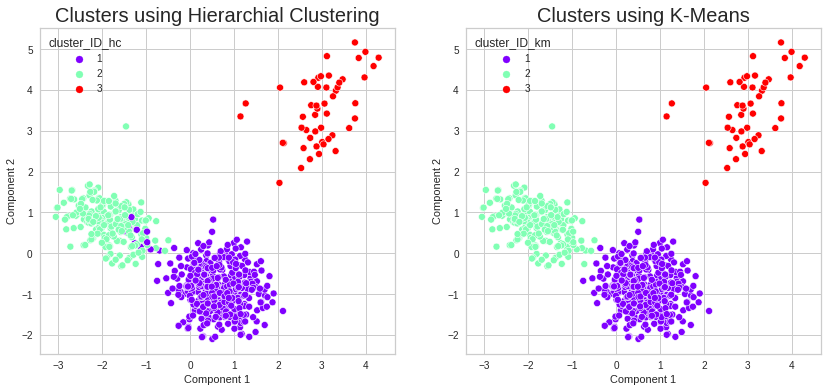

<IPython.core.display.Javascript object>

In [46]:
# setting the number of components to 2
pca = PCA(n_components=2)

# transforming data and storing results in a dataframe
X_reduced_pca = pca.fit_transform(cust_scaled_pca)

reduced_df_pca = pd.DataFrame(
    data=X_reduced_pca, columns=["Component 1", "Component 2"]
)

## Show the scatter plots for clusters formed using two different algirthms
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

## Show cluster using Hierarchial clustering
sns.scatterplot(
    data=reduced_df_pca,
    x="Component 1",
    y="Component 2",
    hue=cust_km_hc["cluster_ID_hc"],
    palette="rainbow",
    ax=axs[0],
)
axs[0].set_title("Clusters using Hierarchial Clustering", fontsize=20)

## Show cluster using K-Means
sns.scatterplot(
    data=reduced_df_pca,
    x="Component 1",
    y="Component 2",
    hue=cust_km_hc["cluster_ID_km"],
    palette="rainbow",
    ax=axs[1],
)
axs[1].set_title("Clusters using K-Means", fontsize=20)

- Here we can see that in Hierarchial clustering some data points of cluster 1 are penetrating the cluster 2
- Using K-Means, we can see that those data points are no longer there.
- Let's see if we can isolate those points on the scatter plot.

Text(0.5, 1.0, 'Clusters using Hierarchial Clustering with Mislabeled data')

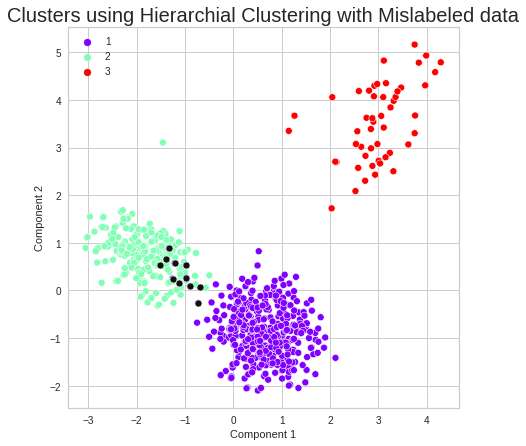

<IPython.core.display.Javascript object>

In [47]:
reduced_df_pca["km"] = cust_km_hc["cluster_ID_km"]
reduced_df_pca["hc"] = cust_km_hc["cluster_ID_hc"]
mislabeled_points = reduced_df_pca[
    (reduced_df_pca["hc"] == 1) & (reduced_df_pca["km"] == 2)
]

## Show the scatter plots for clusters formed using two different algirthms
fig, axs = plt.subplots(1, 1, figsize=(7, 7))

## Show cluster using Hierarchial clustering
sns.scatterplot(
    data=reduced_df_pca,
    x="Component 1",
    y="Component 2",
    hue=cust_km_hc["cluster_ID_hc"],
    palette="rainbow",
    ax=axs,
)
## Show points which got labeled by hierarchical clustering as 1 but k-means clustering labeled them as 2
## these points will be shown in black
sns.scatterplot(
    data=mislabeled_points, x="Component 1", y="Component 2", color="k", ax=axs,
)
axs.set_title("Clusters using Hierarchial Clustering with Mislabeled data", fontsize=20)

- Once we have isolated those points, we can clearly see that these data points are in the cluster 2 data points, and hierarchial clustering is not able to isolated them.
- Hence, we will provide **our business recommendations based on K-Means clustering**
- Also, we can look at the clusters in 3D as an additional visulization

### Let's visualize 3D cluster using 3 feature PCA 

In [48]:
%matplotlib notebook
# setting the number of components to 2
pca = PCA(n_components=3)

# transforming data and storing results in a dataframe
X_reduced_pca = pca.fit_transform(cust_scaled_pca)

reduced_df_pca = pd.DataFrame(
    data=X_reduced_pca, columns=["Component 1", "Component 2", "Component 3"]
)
reduced_df_pca["km"] = cust_km_hc["cluster_ID_km"]
reduced_df_pca["hc"] = cust_km_hc["cluster_ID_hc"]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


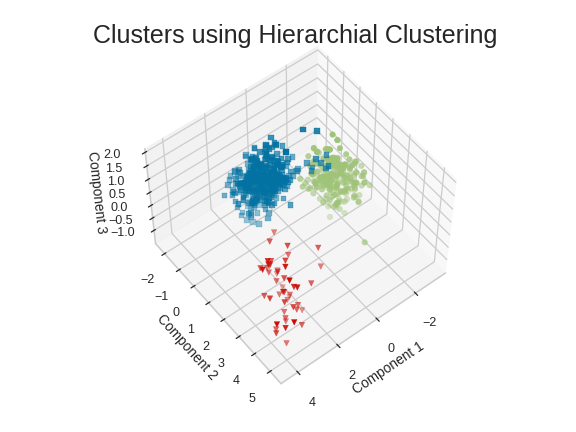

<IPython.core.display.Javascript object>

In [49]:
## Plot the cluster using Hierarchial clustering
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
colors = ["b", "g", "r"]
markers = ["s", "o", "v"]
for i, s in enumerate(reduced_df_pca.km.unique()):
    ax.scatter(
        reduced_df_pca[reduced_df_pca["hc"] == s]["Component 1"],
        reduced_df_pca[reduced_df_pca["hc"] == s]["Component 2"],
        reduced_df_pca[reduced_df_pca["hc"] == s]["Component 3"],
        c=colors[i],
        marker=markers[i],
    )
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.set_title("Clusters using Hierarchial Clustering", fontsize=20)
ax.view_init(54, 52)

<IPython.core.display.Javascript object>


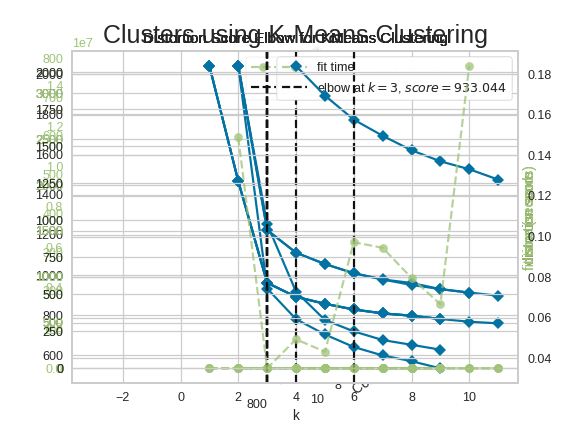

<IPython.core.display.Javascript object>

In [50]:
## Plot the cluster using K-Means clustering
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
colors = ["b", "g", "r"]
markers = ["s", "o", "v"]
for i, s in enumerate(reduced_df_pca.km.unique()):
    ax.scatter(
        reduced_df_pca[reduced_df_pca["km"] == s]["Component 1"],
        reduced_df_pca[reduced_df_pca["km"] == s]["Component 2"],
        reduced_df_pca[reduced_df_pca["km"] == s]["Component 3"],
        c=colors[i],
        marker=markers[i],
    )
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.set_title("Clusters using K-Means Clustering", fontsize=20)
ax.view_init(54, 52)

## Summary and Business reccomendations

- ### Summary  <br>

    - We have analyzed credit card customer dataset using two different segmentation algorithms
        - K-Means clustering
        - Hierarchical clustering
    - Both algorithms gave nearly same clusters, except 11 (1.67% of overall data) data points which were labeled by hierarchical clustering as 1 but labeled as cluster 2 by K-Means
        - After close observations using PCA analysis and visualizing the data in a reduced fetaure space, we conlcluded that **K-Means clustering is more accurate in clustering** compared to Hierarchial clustering.
    - Characteristics of the 3 clusters are as follows,
        - **_Cluster 1_**
            - It is the largest cluster with 386 data points in it.
            - It is characterized by medium credit limit and medium number of total credit cards
            - The customers in this cluster visit the bank more frequently than other customers and use online banking minimally
            - Their call frequency to the bank is medium
        - **_Cluster 2_**
            - It is the second largest cluster with 224 data points in it.
            - It is characterized by low credit limit and lowest number of total credit cards
            - The customers in this cluster call the bank more frequently than other customers
            - Their bank visit and online banking usage frequency is medium
        - **_Cluster 3_**
            - It is the smallest cluster with 50 data points in it.
            - It is characterized by high credit limit and highest number of total credit cards
            - The customers in this cluster visit the bank use online banking most frequently than other customers
            - Their call and bank visit frequency is also lowest
            - Based on our EDA, we identified this group of customers to be the outliers in the credit limit and total credit cards distribution

- ### Business Recommendations   <br>

- Here we will provide cluster specific business recommendations.

    - **_Cluster 1_**
        - Bank should target this cluster to upsell credit cards services as they are clearly in between the other two clusters in terms of avg credit limit and total credit cards. Hence they are most easy to transition into getting more credit cards.
        - Their online banking skills are decent but they still rely on calling more. So there is a potential to offer them training on how to use online banking. 
        - Since they use phone service more often, their feedback could be really important in improving the calling experience. One other venue could be to use this feedback to develop more sophisticated automated calling system
        
    - **_Cluster 2_**
        - Bank could target this cluster to upsell credit cards services as they have lowest number of credit cards and lowest credit limit.
        - It could be worthwhile to look into why they have lower credit limits and fewer credit cards. As this group also relies heavily on visting banks, that indicates they do not understand the financial system of credit cards. This would help to better cater them credit cards for their needs.
        - This group visits banks more often than any other. Running a brick and mortar bank requires in-person staff and is an expense to the company. Hence, some training on banking over calling or online banking can be helpful for this group. 
        - Their feedback on their visits can also help to tune the in-person visit experience and to identify what is missing and what is not needed in the brick and mortar bank
        
    - **_Clsuter 3_**
        - This group is the smallest of all but has highest credit limit and credit cards.
        - This group also hevaily relies on online banking which means they do not require face to face or voice to voice with a a bank employee, hence their feedback is curcial for UI design and improvement.
        - The bank should try to increase this customer base by offering them reward for referrals, as they most likely belong to a circle of people who are capable of maintaining high credit limit and number of credit cards like them.